In [1]:
import librosa
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import os

In [2]:
import soundfile as sf
import matplotlib.pyplot as plt


## Combine 120 sound files to one

In [3]:
num_file_to_combine = 120

datset_path = "16000_pcm_speeches"
output_path = "combined_voice"

speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

# for speaker_f in speaker_folders:
#     speaker_path = os.path.join(datset_path, speaker_f)
    
#     #list the first 120 .wav files
#     wave_files = [f"{i}.wav" for i in range(num_file_to_combine)]

#     #combine the first 120 .wav files
#     combined_wave = []
#     for wave_file in wave_files:
#         wave, sr = librosa.load(os.path.join(speaker_path, wave_file), sr=None)
#         combined_wave.extend(wave)

#     #save the combined wave
#     speaker_output_path = os.path.join(output_path, f"{speaker_f}_combined.wav")
#     sf.write(speaker_output_path, np.array(combined_wave), sr)


## Data visualization

In [4]:
# import librosa.display

# def plot_audio_feature(audio_path):
#     y, sr = librosa.load(audio_path, sr=None)

#     speaker_name = os.path.basename(audio_path).split('_')[0]


#     plt.figure(figsize=(15, 10))
#     plt.subplot(3, 1, 1)
#     librosa.display.waveshow(y, sr=sr)
#     plt.title(f'Waveform - {speaker_name}')

#     plt.subplot(3, 1, 2)
#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
#     librosa.display.specshow(mfccs, sr=sr, x_axis='time')
#     plt.title(f'MFCC - {speaker_name}')

#     plt.subplot(3, 1, 3)
#     mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
#     librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time')
#     plt.title(f'Mel Spectrogram - {speaker_name}')

#     plt.tight_layout()
#     plt.show()


# audio_path= [
#     "combined_voice\Benjamin_Netanyau_combined.wav",
#     "combined_voice\Jens_Stoltenberg_combined.wav",
# ]


# for audio in audio_path:
#     plot_audio_feature(audio)
    


## Feature Extraction

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:

def feature_extraction(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker)

        for file_name in os.listdir(speaker_folder_path):
            if file_name.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path,file_name)
                audio , sr = librosa.load(file_path , sr= None, duration=1)
                mfccs = librosa.feature.mfcc(y=audio, sr = sr, n_mfcc= 13) 
                ## NO. OF MFCCS WE NEED
                mfccs = StandardScaler().fit_transform(mfccs)
                features.append(mfccs.T)
                labels.append(i)

    
    return np.array(features), np.array(labels)


X , Y = feature_extraction(datset_path, speaker_folders)


In [7]:
#what was the time duration of the audio file in seconds

print(X.shape)
print(Y.shape)

print(X[0].shape)




(7501, 32, 13)
(7501,)
(32, 13)


In [8]:
print(X)

[[[-3.4641016   0.2887172   0.28871483 ...  0.2886389   0.2886224
    0.2886044 ]
  [-3.4641016   0.2886977   0.28869638 ...  0.2886557   0.28864682
    0.2886371 ]
  [-3.4641018   0.28869462  0.28869352 ...  0.28865835  0.2886507
    0.28864226]
  ...
  [-3.3067386   1.0927988   0.09423477 ... -0.01679934  0.06416836
   -0.01576676]
  [-3.302511    1.1125711   0.11559542 ...  0.02531367  0.07413579
   -0.01616776]
  [-3.320979    1.0881165   0.1504413  ...  0.02759937  0.14088126
    0.07228283]]

 [[-3.3293808   1.1152196   0.15280247 ...  0.04381237  0.10148772
    0.04075786]
  [-3.2763088   1.216366    0.11081342 ...  0.0041197   0.03439333
    0.02838666]
  [-3.2889938   1.1915864   0.14888133 ...  0.00728869  0.05132583
    0.04958135]
  ...
  [-0.62854373  2.531994   -2.2210534  ...  0.2865067   0.04549608
   -0.5743097 ]
  [-0.30689606  2.5076501  -2.3356664  ...  0.04502293 -0.01954037
   -0.61852497]
  [-0.8376341   2.6435595  -1.965699   ... -0.21581315 -0.09344908
   -0.22

## Train n Test split

In [9]:
from sklearn.preprocessing import LabelEncoder


In [10]:
X.shape

(7501, 32, 13)

In [11]:

label_encoder = LabelEncoder()
Y= label_encoder.fit_transform(Y)
label_encoder.classes_= np.array(speaker_folders)

X_train, X_test , Y_train , Y_test = train_test_split(X,Y ,test_size= 0.98 , random_state= 42)

print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

Training Data Shape: (150, 32, 13)
Test Data Shape: (7351, 32, 13)


## Trying a basic SVM model

In [12]:
from sklearn.svm import SVC

X_train_flat= X_train.reshape(X_train.shape[0],-1)
X_test_flat= X_test.reshape(X_test.shape[0],-1)


svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_classifier.fit(X_train_flat, Y_train)



SVC()

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Y_predict = svm_classifier.predict(X_test_flat)

class_report = classification_report(Y_predict,Y_test)
print(class_report)


              precision    recall  f1-score   support

           0       0.52      0.55      0.53      1391
           1       0.61      0.61      0.61      1479
           2       0.76      0.95      0.84      1189
           3       0.79      0.69      0.74      1659
           4       0.99      0.89      0.94      1633

    accuracy                           0.73      7351
   macro avg       0.73      0.74      0.73      7351
weighted avg       0.74      0.73      0.74      7351



In [14]:
confusion_matrix = confusion_matrix(Y_test, Y_predict)
print(confusion_matrix)

[[ 765  429   12  263    0]
 [ 414  898   42  108    8]
 [  27   22 1124  135  167]
 [ 185  130    0 1153    0]
 [   0    0   11    0 1458]]


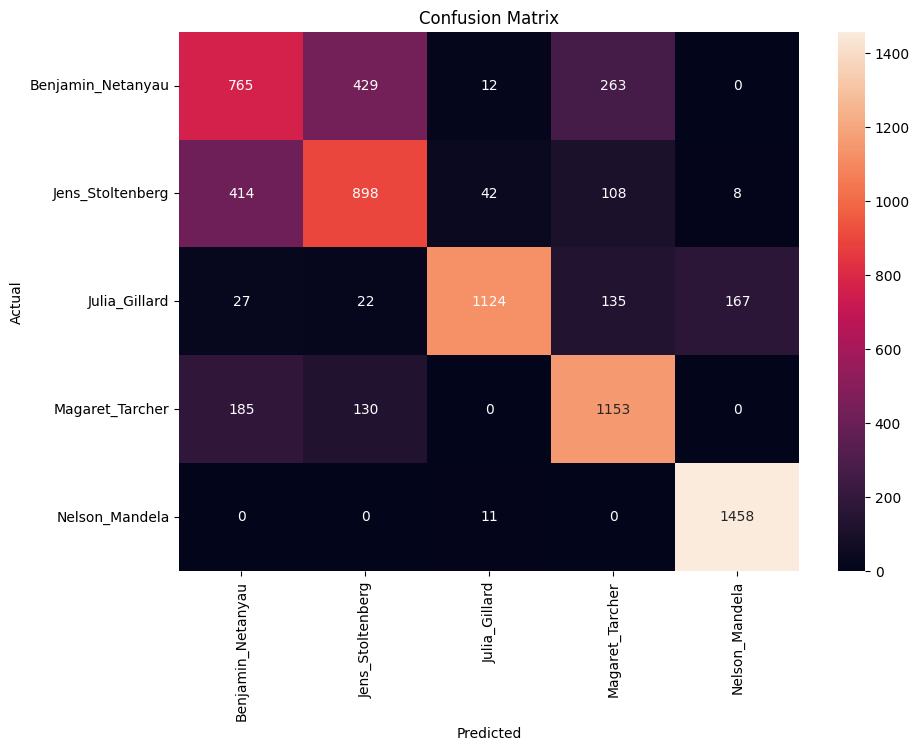

In [15]:
import seaborn as sns

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', xticklabels=speaker_folders, yticklabels=speaker_folders)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()